# Описание данных

- **CustomerId**: Уникальный идентификатор для каждого клиента.
- **Surname**: Фамилия клиента.
- **CreditScore**: Кредитный рейтинг клиента.
- **Geography**: Географическое местоположение клиента (страна).
- **Gender**: Пол клиента.
- **Age**: Возраст клиента.
- **Tenure**: Количество лет обслуживания клиента в банке.
- **Balance**: Баланс счета клиента.
- **NumOfProducts**: Количество банковских продуктов, используемых клиентом.
- **HasCrCard**: Указывает, есть ли у клиента кредитная карта (бинарное: да/нет).
- **IsActiveMember**: Указывает, является ли клиент активным пользователем (бинарное: да/нет).
- **EstimatedSalary**: Оценочная зарплата клиента.
- **Exited**: Указывает, покинул ли клиент банк (бинарное: да/нет).

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

In [3]:
df = pd.read_csv('Churn_Modelling.csv', index_col='RowNumber')

df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 13)

# EDA

##### Для начала удалим столбцы Surname и Customer_id

In [5]:
df = df.drop(columns=['CustomerId', 'Surname'])

##### Посмотрим на пропущенные значения

In [6]:
df.isna().sum().sum()

0

Как видим, в данных нет пропущенных значений.

##### Посмотрим на выбросы

In [7]:
# Функция для определения выбросов с использованием межквартильного размаха (IQR)
def detect_outliers_iqr(data, column):
    Q1 = np.percentile(data[column], 25)  # Первый квартиль (25%)
    Q3 = np.percentile(data[column], 75)  # Третий квартиль (75%)
    IQR = Q3 - Q1  # Межквартильный размах
    lower_bound = Q1 - 1.5 * IQR  # Нижняя граница выбросов
    upper_bound = Q3 + 1.5 * IQR  # Верхняя граница выбросов
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    return outliers

# Применяем функцию к числовым признакам
numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for feature in numerical_features:
    outliers = detect_outliers_iqr(df, feature)
    print(f"Признак {feature}: найдено {len(outliers)} выбросов")


Признак CreditScore: найдено 15 выбросов
Признак Age: найдено 359 выбросов
Признак Balance: найдено 0 выбросов
Признак EstimatedSalary: найдено 0 выбросов


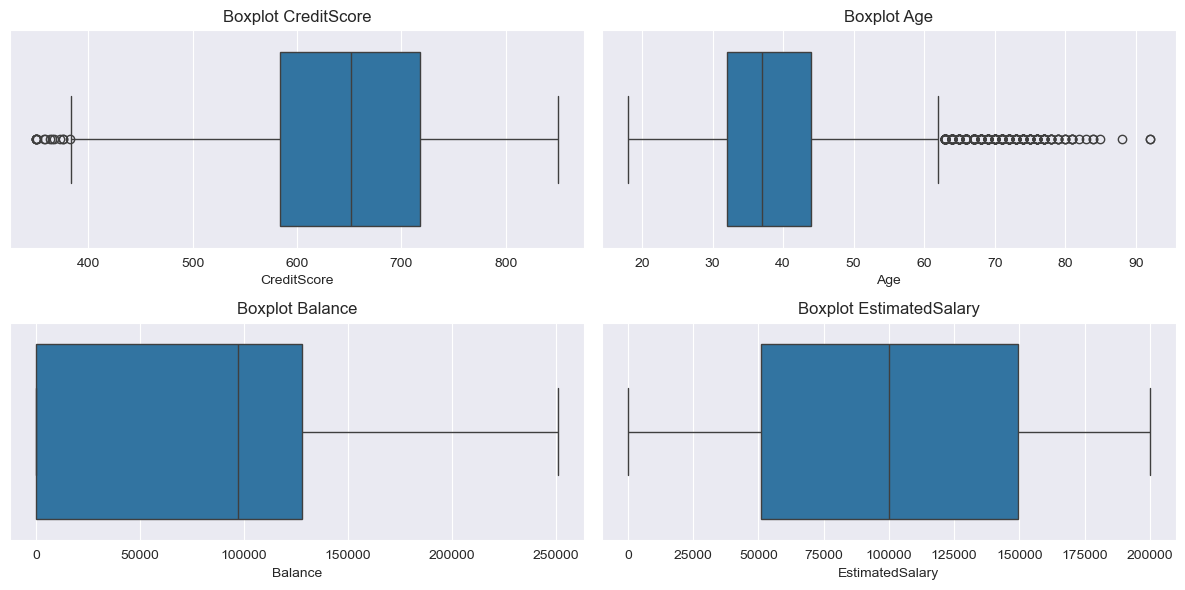

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot {feature}')
plt.tight_layout()
plt.show()

### Анализ целевой переменной

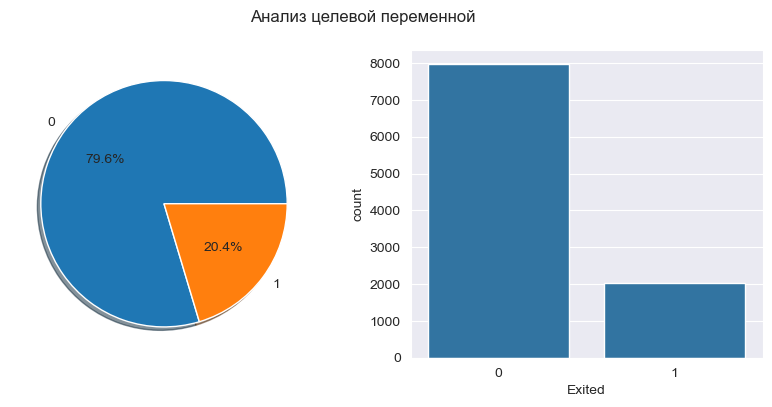

In [9]:
f,ax=plt.subplots(1,2,figsize=(10,4))
df['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Exited',data=df,ax=ax[1])
plt.suptitle('Анализ целевой переменной')
plt.show()

Данные сильно несбалансированы. Почти 80% наших данных относятся к классу 0 (не ушли), а 20% данных относятся к классу 1 (ушли).

В реальной жизни мы интересуемся только людьми, которые уходят из банка, и хотим проанализировать только закономерности этих людей.

### Анализ категориальных признаков

В наших данных категориальные переменные:
- Geography
- Gender
- Tenure
- NumOfProducts
- HasCrCard
- IsActiveMember

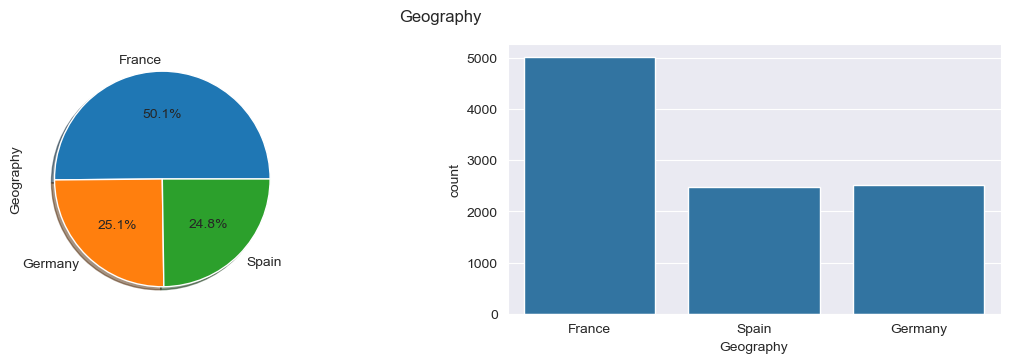

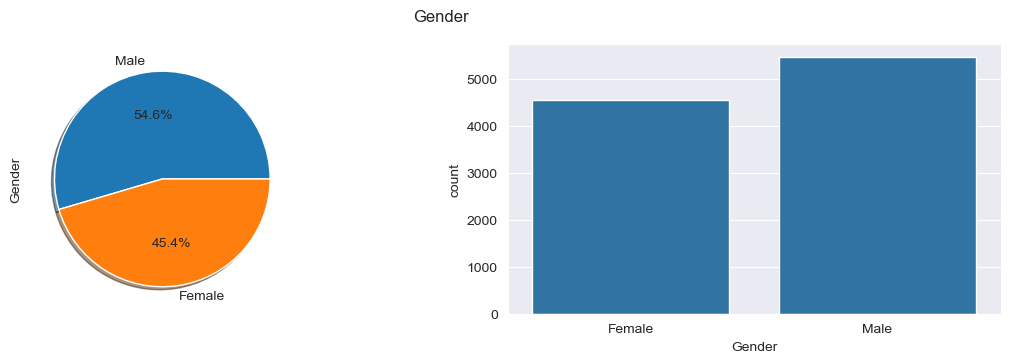

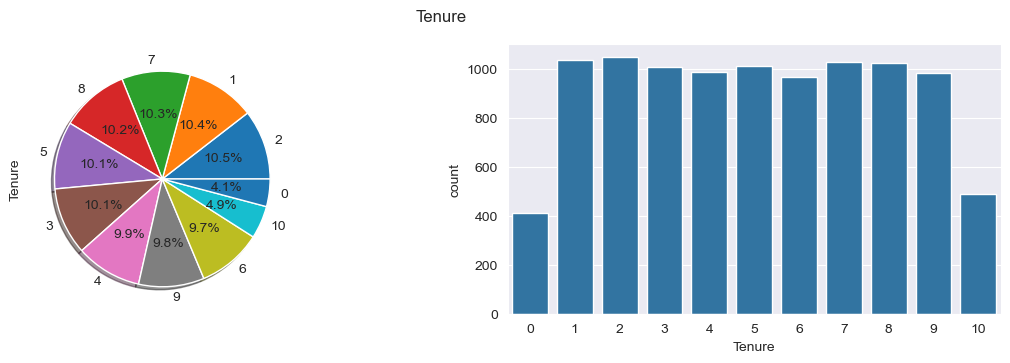

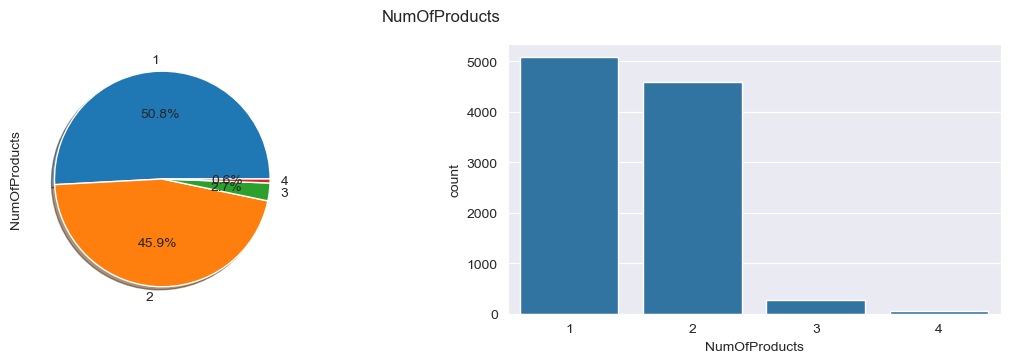

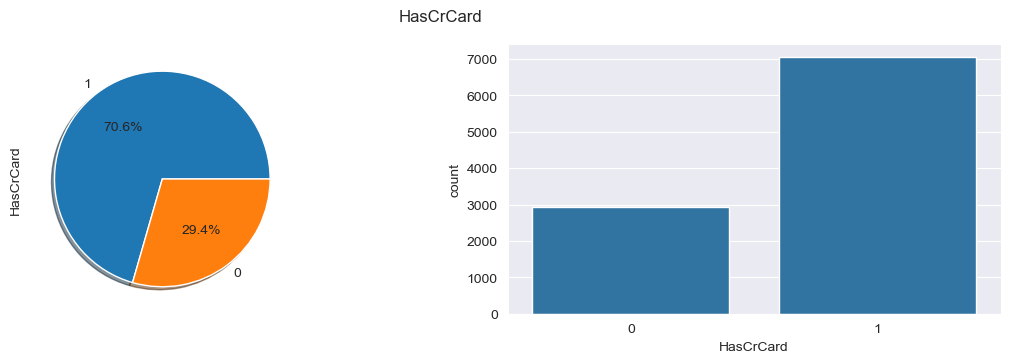

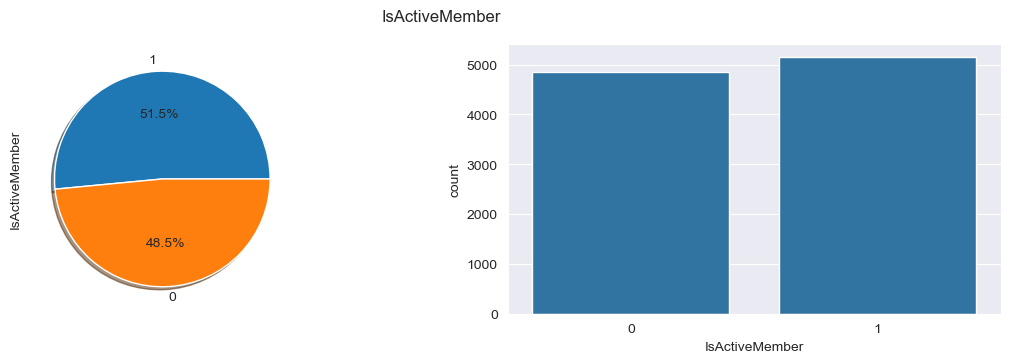

In [10]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

for column in categorical_columns:
    f, ax=plt.subplots(1,2,figsize=(14,3.5))
    df[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=df,ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

Некоторые наблюдения из приведенных выше графиков:

Некоторые переменные, такие как `IsActiveMember`, `Tenure` и `Gender`, распределены почти равномерно, в то время как другие переменные, такие как `HasCrCard`, `NumOfProducts` и `Gender`, распределены неравномерно.
На первый взгляд `Tenure` кажется непрерывной переменной, но это категориальная переменная с 11 классами от 0 до 10.

### Анализ численных переменных

В наших данных непрерывными переменными являются:
- CreditScore
- Age
- Balance
- EstimatedSalary

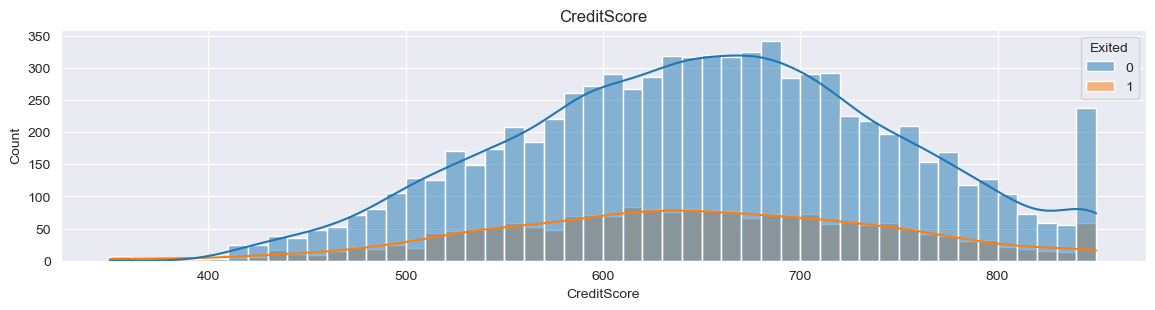

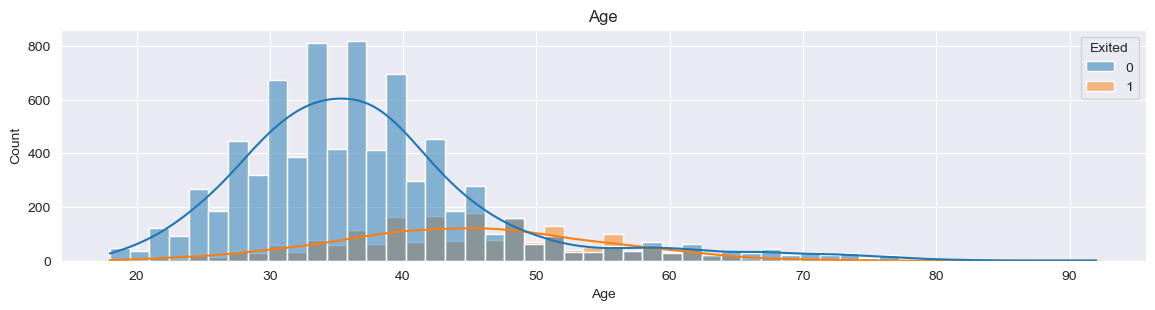

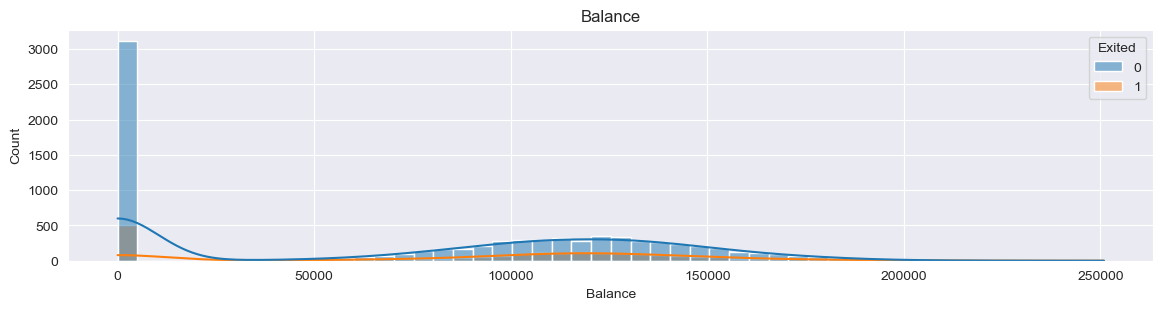

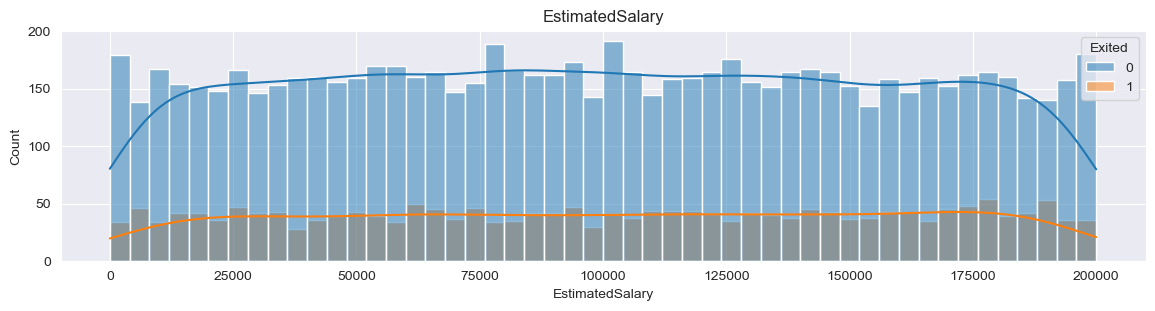

In [11]:
continuous_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for column in continuous_columns:
    fig, ax = plt.subplots(figsize=(14, 3))
    fig = sns.histplot(data=df, x=column, hue="Exited", bins=50, kde=True)
    plt.title(column)
    plt.show()

Некоторые наблюдения из приведенных выше графиков:

- Большинство данных из переменной `balance` равно 0, что делает распределение смещенным в сторону 0.
- Другие переменные также показывают смещение в распределениях.
- Распределение данных для обоих классов почти одинаково для всех переменных

##### Кодирование строковых значений

В данном случае, для моделей из разных стран у нас один строковый столбец - `Gender`
А для общей модели 2 признака

In [12]:
# OHE для одного признака Gender
encoder_gender = OneHotEncoder(sparse_output=False, drop='first')
encoded_gender = encoder_gender.fit_transform(df[['Gender']])
gender_cols = encoder_gender.get_feature_names_out(['Gender'])
df_gender = pd.DataFrame(encoded_gender, columns=gender_cols, index=df.index)

# OHE для двух признаков Gender и Geography
encoder_both = OneHotEncoder(sparse_output=False, drop='first')
encoded_both = encoder_both.fit_transform(df[['Gender', 'Geography']])
both_cols = encoder_both.get_feature_names_out(['Gender', 'Geography'])
df_both = pd.DataFrame(encoded_both, columns=both_cols, index=df.index)

# Добавляем закодированные признаки в датафреймы
df_with_gender = pd.concat([df.drop(columns='Gender'), df_gender], axis=1)
df_general = pd.concat([df.drop(columns=['Gender', 'Geography']), df_both], axis=1)

df = df_with_gender.copy()

df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male
RowNumber,,,,,,,,,,,
1,619,France,42,2,0.00,1,1,1,101348.88,1,0.0
2,608,Spain,41,1,83807.86,1,0,1,112542.58,0,0.0
3,502,France,42,8,159660.80,3,1,0,113931.57,1,0.0
4,699,France,39,1,0.00,2,0,0,93826.63,0,0.0
5,850,Spain,43,2,125510.82,1,1,1,79084.10,0,0.0


In [13]:
df_general.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0.0,0.0,0.0
2,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
3,502,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0,0.0
4,699,39,1,0.00,2,0,0,93826.63,0,0.0,0.0,0.0
5,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


### Смотрим на корреляцию

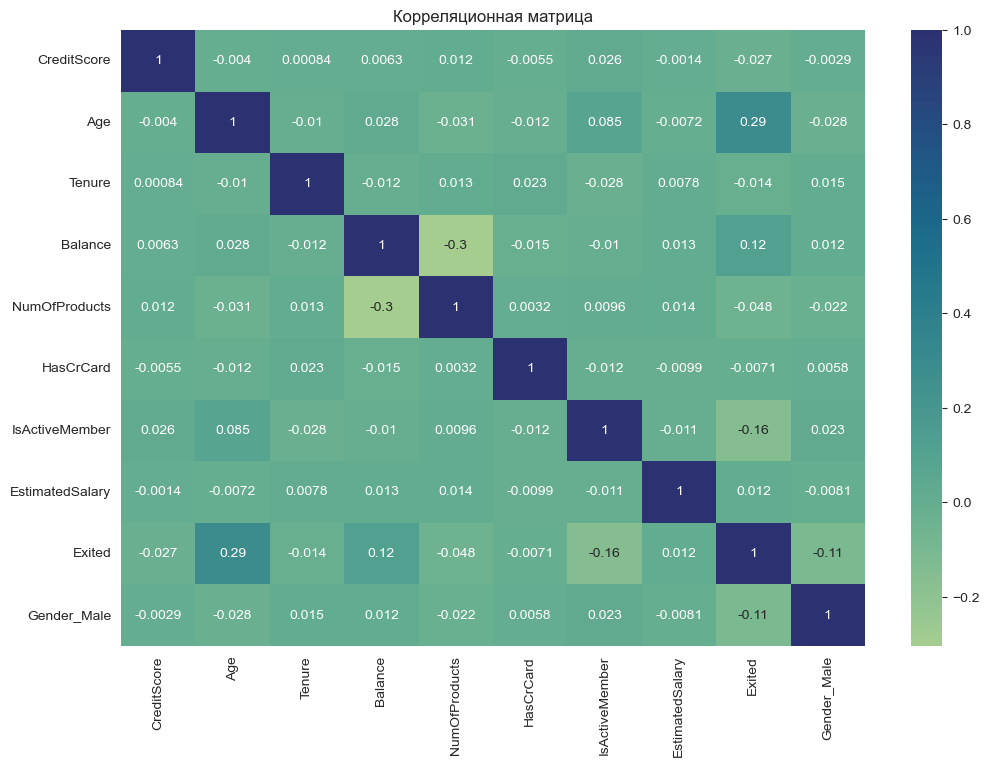

In [14]:
correlation_matrix = df.drop(columns='Geography').corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest')
plt.title("Корреляционная матрица")
plt.show()

1. Корреляция признаков с целевой переменной **Exited**:
- **Age (Возраст)** имеет умеренную положительную корреляцию с Exited (0.29). Это может означать, что с увеличением возраста вероятность оттока увеличивается.
- **IsActiveMember (Активность клиента)** показывает отрицательную корреляцию (-0.16). Менее активные клиенты чаще покидают банк.
2. Корреляции между признаками:
- **NumOfProducts** и **Balance** имеют отрицательную корреляцию (-0.3). Это может означать, что клиенты с большим балансом, как правило, используют меньше продуктов.
- Остальные корреляции между признаками достаточно низкие, что может указывать на их относительную независимость.

# Предобработка данных

#### Разбиение по странам

In [15]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [16]:
france_data = df[df['Geography'] == 'France']
france_data = france_data.drop(columns='Geography')

germany_data = df[df['Geography'] == 'Germany']
germany_data = germany_data.drop(columns='Geography')

spain_data = df[df['Geography'] == 'Spain']
spain_data = spain_data.drop(columns='Geography')

#### Разбиение на тренировочную и тестовую выборки

In [17]:
from sklearn.preprocessing import StandardScaler

# Общий сплит
general_X_train, general_X_test, general_y_train, general_y_test = train_test_split(
    df_general.drop(columns='Exited'),
    df_general['Exited'],
    test_size=0.3, random_state=42)

# scaler_general = StandardScaler()
# general_X_train = scaler_general.fit_transform(general_X_train)
# general_X_test = scaler_general.transform(general_X_test)

# Франция
france_X_train, france_X_test, france_y_train, france_y_test = train_test_split(
    france_data.drop(columns='Exited'),
    france_data['Exited'],
    test_size=0.3, random_state=42)

# scaler_france = StandardScaler()
# france_X_train = scaler_france.fit_transform(france_X_train)
# france_X_test = scaler_france.transform(france_X_test)

# Испания
spain_X_train, spain_X_test, spain_y_train, spain_y_test = train_test_split(
    spain_data.drop(columns='Exited'),
    spain_data['Exited'],
    test_size=0.3, random_state=42)

# scaler_spain = StandardScaler()
# spain_X_train = scaler_spain.fit_transform(spain_X_train)
# spain_X_test = scaler_spain.transform(spain_X_test)

# Германия
germany_X_train, germany_X_test, germany_y_train, germany_y_test = train_test_split(
    germany_data.drop(columns='Exited'),
    germany_data['Exited'],
    test_size=0.3, random_state=42)

In [18]:
print('Кол-во данных из стран:\n')
print('\tTrain set   Test set')
print('General:', general_X_train.shape, general_X_test.shape)
print('France:', france_X_train.shape, france_X_test.shape)
print('Spain:', spain_X_train.shape, spain_X_test.shape)
print('Germany:', germany_X_train.shape, germany_X_test.shape)

Кол-во данных из стран:

	Train set   Test set
General: (7000, 11) (3000, 11)
France: (3509, 9) (1505, 9)
Spain: (1733, 9) (744, 9)
Germany: (1756, 9) (753, 9)


# Построение моделей

In [19]:
# Словарь с данными: ключ – название набора данных, значение – кортеж (X_train, y_train, X_test, y_test)
datasets = {
    "Общая": (general_X_train, general_y_train, general_X_test, general_y_test),
    "France": (france_X_train, france_y_train, france_X_test, france_y_test),
    "Spain": (spain_X_train, spain_y_train, spain_X_test, spain_y_test),
    "Germany": (germany_X_train, germany_y_train, germany_X_test, germany_y_test)
}

def evaluate_model(model_constructor, params, model_label):
    """
    Обучает модель для каждого набора данных, рассчитывает метрики и возвращает список словарей с результатами.

    :param model_constructor: конструктор модели (например, LogisticRegression)
    :param params: словарь параметров модели
    :param model_label: название модели для отображения
    :return: список словарей с результатами
    """
    results = []
    for dataset_name, (X_train, y_train, X_test, y_test) in datasets.items():
        # Создаем и обучаем модель
        model = model_constructor(**params, random_state=42)
        model.fit(X_train, y_train)

        # Получение предсказанных вероятностей для вычисления ROC-AUC
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Получение отчета по метрикам (output_dict=True)
        report = classification_report(y_test, model.predict(X_test), output_dict=True)
        accuracy = report['accuracy']
        f1_class_1 = report['1']['f1-score']  # F1 для класса "1"
        f1_class_0 = report['0']['f1-score']  # F1 для класса "0"

        # Сохранение результатов в список
        results.append({
            'Модель': model_label,
            'Набор данных': dataset_name,
            'ROC_AUC': round(roc_auc, 4),
            'Accuracy': round(accuracy, 4),
            'F1 Class 1': round(f1_class_1, 4),
            'F1 Class 0': round(f1_class_0, 4)
        })
    return results


# Список для накопления всех результатов
all_results = []

### Логистическая регрессия

In [20]:
lr_params = {
    'class_weight': 'balanced',
    'max_iter': 7000
}
all_results.extend(evaluate_model(LogisticRegression, lr_params, "LogisticRegression"))

pd.DataFrame(all_results)

,Модель,Набор данных,ROC_AUC,Accuracy,F1 Class 1,F1 Class 0
0,LogisticRegression,Общая,0.7750,0.7017,0.4775,0.7912
1,LogisticRegression,France,0.7701,0.7196,0.4631,0.8103
2,LogisticRegression,Spain,0.7622,0.6680,0.4348,0.7650
3,LogisticRegression,Germany,0.7568,0.7025,0.6254,0.7533


**Точность (Accuracy)** высока для всех стран: 72% (Франция), 67% (Испания), 70% (Германия). У общей модели 70%
**ROC-AUC** также высок для всех стран: 77%, 76%, 75%. У общей модели 77%

Основная проблема:
Низкая метрика **f1-score** для класса 1 (ушедшие клиенты) во всех моделях:
- Франция: 0.46
- Испания: 0.43
- Германия: 0.62
- Общая модель: 0.48


### Дерево решений

In [21]:
# ----- Дерево решений -----
dt_params = {
    'class_weight': 'balanced'
}
all_results.extend(evaluate_model(DecisionTreeClassifier, dt_params, "DecisionTree"))

pd.DataFrame(all_results)

,Модель,Набор данных,ROC_AUC,Accuracy,F1 Class 1,F1 Class 0
0,LogisticRegression,Общая,0.7750,0.7017,0.4775,0.7912
1,LogisticRegression,France,0.7701,0.7196,0.4631,0.8103
2,LogisticRegression,Spain,0.7622,0.6680,0.4348,0.7650
3,LogisticRegression,Germany,0.7568,0.7025,0.6254,0.7533
4,DecisionTree,Общая,0.6911,0.8037,0.5013,0.8778
5,DecisionTree,France,0.6900,0.8319,0.4930,0.8992
6,DecisionTree,Spain,0.6377,0.7903,0.4091,0.8725
7,DecisionTree,Germany,0.6569,0.6906,0.5528,0.7635


**Точность (Accuracy)** улучшилась для всех стран, кроме Германии: 83% (Франция), 79% (Испания), 69% (Германия). У общей модели 80%
**ROC-AUC** ухудшился для всех стран: 69%, 63%, 65%. У общей модели 69%

Основная проблема:
Низкая метрика **f1-score** для класса 1 (ушедшие клиенты) сохраняется во всех моделях.

### Random Forest

Переход на более сложные модели, попробуем Random Forest

Подбор гиперпараметров

In [22]:
# # Определение параметров для поиска
# param_grid = {
#     'n_estimators': [350, 400, 450],
#     'max_depth': [7, 8, 9],
#     'min_samples_split': [15, 20, 25],
#     'min_samples_leaf': [3, 5, 7],
#     'class_weight': ['balanced', 'balanced_subsample']
# }
#
# rf_model = RandomForestClassifier(random_state=42)
#
# # Инициализация Grid Search с кросс-валидацией
# grid_search = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=5,  # 5-кратная кросс-валидация
#     verbose=2,  # Уровень логирования
#     n_jobs=-1  # Использование всех доступных процессоров
# )
#
# # Выполнение поиска на тренировочных данных (для Франции)
# grid_search.fit(france_X_train, france_y_train)
#
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучший ROC-AUC на валидации:", grid_search.best_score_)

In [23]:
# ----- Random Forest -----
rf_params = {
    'n_estimators': 250,
    'max_depth': 10,
    'min_samples_split': 12,
    'min_samples_leaf': 2,
    'class_weight': 'balanced'
}
all_results.extend(evaluate_model(RandomForestClassifier, rf_params, "RandomForest"))

pd.DataFrame(all_results)

,Модель,Набор данных,ROC_AUC,Accuracy,F1 Class 1,F1 Class 0
0,LogisticRegression,Общая,0.7750,0.7017,0.4775,0.7912
1,LogisticRegression,France,0.7701,0.7196,0.4631,0.8103
2,LogisticRegression,Spain,0.7622,0.6680,0.4348,0.7650
3,LogisticRegression,Germany,0.7568,0.7025,0.6254,0.7533
4,DecisionTree,Общая,0.6911,0.8037,0.5013,0.8778
5,DecisionTree,France,0.6900,0.8319,0.4930,0.8992
6,DecisionTree,Spain,0.6377,0.7903,0.4091,0.8725
7,DecisionTree,Germany,0.6569,0.6906,0.5528,0.7635
8,RandomForest,Общая,0.8670,0.8423,0.6231,0.9003
9,RandomForest,France,0.8486,0.8631,0.5977,0.9175


**Точность (Accuracy)** увеличилась для всех стран (По сравнению с деревом решений):

Франция: 86% (рост на 3%),
Испания: 86% (рост на 7%),
Германия: 82% (рост на 13%).
Общая модель: 84% (рост на 4%)

**Метрика ROC-AUC** также улучшилась (по сравнению с Линейной моделью):

Франция: 85% (рост на 8%),
Испания: 84% (рост на 8%),
Германия: 87% (рост на 12%).
Общая модель: 87% (рост на 9%)

Ранее наблюдалась **проблема низкого значения метрики f1-score** для класса 1 (ушедшие клиенты). После доработки удалось существенно улучшить результат:

Франция: 0.49 (DT) → 0.60,
Испания: 0.43 (LR) → 0.60,
Германия: 0.63 (LR) → 0.75.
Общая модель: 0.5 (DT) -> 0.62

Как можно заметить, у моделей с большей точностью меньше ROC-AUC, это означает что у них сильный дисбаланс классов и в этом случае лучше опираться на метрику ROC-AUC и F1. У модели Германии большой F1, так как там низкий дисбаланс классов.

### Градиентный бустинг

Попробуем ещё улучшить метрики

In [24]:
# from sklearn.model_selection import GridSearchCV
#
# # Определение параметров для поиска гиперпараметров через Grid Search
# param_grid = {
#     'learning_rate': [0.01, 0.05],           # шаг обучения
#     'n_estimators': [100, 300],         # количество деревьев
#     'max_depth': [3, 5, 7],                    # глубина дерева
#     'min_child_weight': [1, 3],                 # минимальный вес в листе (аналог min_samples_leaf)
#     'gamma': [0, 0.1],                     # минимальное улучшение потерь, чтобы разветвлять узел
#     'subsample': [0.6, 0.8],                  # доля данных на каждое дерево
#     'colsample_bytree': [0.6, 0.8],           # доля признаков на дерево
#     'scale_pos_weight': [1, 2]                  # важно при несбалансированности классов
#
# }
#
# # Инициализация модели XGBoost
# xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
#
# # Инициализация Grid Search с кросс-валидацией (используем данные для Франции в примере)
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=5,        # 5-кратная кросс-валидация
#     verbose=2,   # Подробный лог
#     n_jobs=-1    # Использование всех доступных процессоров
# )
#
# # Поиск оптимальных параметров на тренировочных данных для Франции
# grid_search.fit(general_X_train, general_y_train)
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучший ROC-AUC на валидации:", grid_search.best_score_)

In [25]:
# ----- XGBoost -----
xgb_params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 500,
    'scale_pos_weight': 2,
    'subsample': 0.8,
    'eval_metric': 'logloss'
}
all_results.extend(evaluate_model(XGBClassifier, xgb_params, "XGBoost"))

In [26]:
print("Итоговая таблица с результатами:")
pd.DataFrame(all_results)

Итоговая таблица с результатами:


,Модель,Набор данных,ROC_AUC,Accuracy,F1 Class 1,F1 Class 0
0,LogisticRegression,Общая,0.7750,0.7017,0.4775,0.7912
1,LogisticRegression,France,0.7701,0.7196,0.4631,0.8103
2,LogisticRegression,Spain,0.7622,0.6680,0.4348,0.7650
3,LogisticRegression,Germany,0.7568,0.7025,0.6254,0.7533
4,DecisionTree,Общая,0.6911,0.8037,0.5013,0.8778
5,DecisionTree,France,0.6900,0.8319,0.4930,0.8992
6,DecisionTree,Spain,0.6377,0.7903,0.4091,0.8725
7,DecisionTree,Germany,0.6569,0.6906,0.5528,0.7635
8,RandomForest,Общая,0.8670,0.8423,0.6231,0.9003
9,RandomForest,France,0.8486,0.8631,0.5977,0.9175


**Точность (Accuracy)** увеличился для всех стран, кроме Германии:

Франция: 88% (рост 2%),
Испания: 88% (рост 2%),
Германия: 81% (минус 1%).
Общая модель: 86% (рост 2%)

**Метрика ROC-AUC** также увеличилась для всех стран:

Франция: 85,8% (рост 1%),
Испания: 84,4% (рост 0.4%),
Германия: 87,8% (рост 0.6%).
Общая модель: 86,9% (рост 0.2%)

Незначительно улучшили значения метрики f1-score для класса 1 (ушедшие клиенты):

Франция: 0.46 → 0.60 -> 0.6,
Испания: 0.43 → 0.60 -> 0.62,
Германия: 0.63 → 0.75 -> 0.75.
Общая модель: 0.48 -> 0.62 -> 0.63

Модель XGBoost оказалась лучше других моделей.

Если усреднить точность и roc-auc для моделей разных стран, то будет похожая цифра общей моделей. Но для Германии f1 для класса намного выше чем у общей модели, а фарнция и испания незначительно ниже, то стоит остановиться на выборе моделей разных стран.

Общая модель лучше моделей Испании и Франции по метрики ROC-AUC

### Оценка коэффициентов модели

###### Важность признаков для каждой страны

In [27]:
def feature_importance(model, feature_names):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

# Признаки для каждой страны
general_features = general_X_train.columns
france_features = france_X_train.columns
germany_features = germany_X_train.columns
spain_features = spain_X_train.columns

# Создание и обучение модели XGBoost для каждого набора данных.
general_xgb = XGBClassifier(**xgb_params, random_state=42)
general_xgb.fit(general_X_train, general_y_train)

france_xgb = XGBClassifier(**xgb_params, random_state=42)
france_xgb.fit(france_X_train, france_y_train)

germany_xgb = XGBClassifier(**xgb_params, random_state=42)
germany_xgb.fit(germany_X_train, germany_y_train)

spain_xgb = XGBClassifier(**xgb_params, random_state=42)
spain_xgb.fit(spain_X_train, spain_y_train)

general_importance = feature_importance(general_xgb, general_features)
france_importance = feature_importance(france_xgb, france_features)
germany_importance = feature_importance(germany_xgb, germany_features)
spain_importance = feature_importance(spain_xgb, spain_features)

Важность признаков по странам:
Country              France   General   Germany     Spain  Mean Importance
Feature                                                                   
NumOfProducts      0.224939  0.234615  0.260305  0.195966         0.228956
Age                0.217908  0.195810  0.195052  0.148446         0.189304
IsActiveMember     0.183443  0.175526  0.148519  0.193274         0.175191
Balance            0.084792  0.064719  0.082344  0.120702         0.088139
Gender_Male        0.079927  0.063875  0.085243  0.100680         0.082431
CreditScore        0.054083  0.031665  0.057995  0.074014         0.054439
EstimatedSalary    0.057168  0.028835  0.056021  0.065689         0.051928
Tenure             0.048548  0.030375  0.057453  0.058561         0.048734
HasCrCard          0.049193  0.028873  0.057068  0.042668         0.044451
Geography_Germany  0.000000  0.096127  0.000000  0.000000         0.024032
Geography_Spain    0.000000  0.049580  0.000000  0.000000         0.0

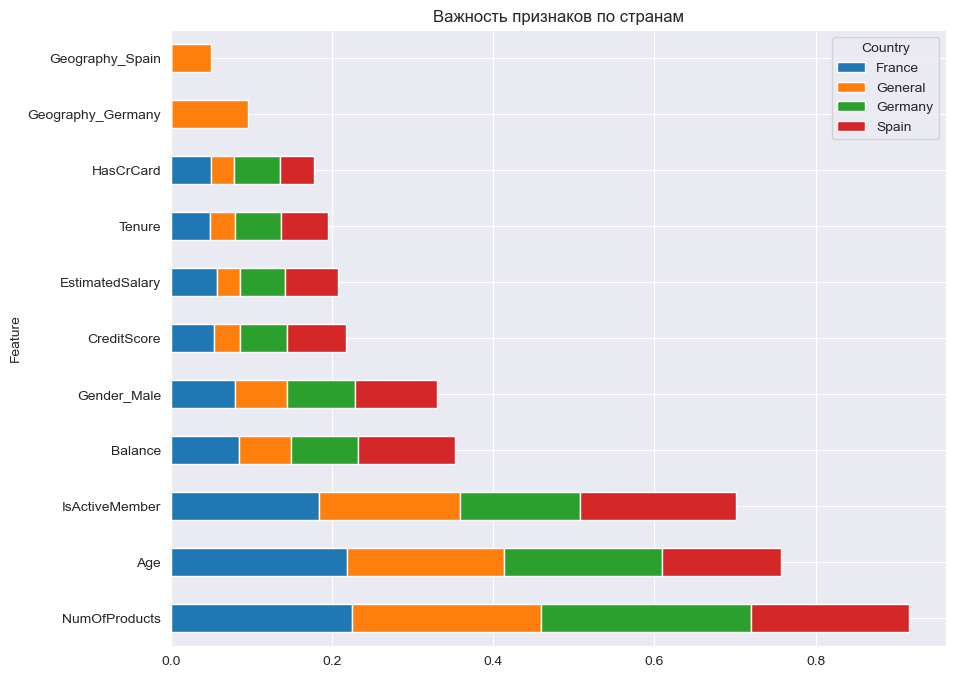

In [28]:
# Объединяем важность признаков для всех стран
def combine_feature_importance(importances, country_names):
    combined_df = pd.DataFrame()
    for importance, country in zip(importances, country_names):
        importance['Country'] = country
        combined_df = pd.concat([combined_df, importance], axis=0)
    return combined_df.reset_index(drop=True)

# Создаем таблицу
countries = ["General", "France", "Germany", "Spain"]
combined_importance = combine_feature_importance(
    [general_importance, france_importance, germany_importance, spain_importance],
    countries
)

# Переходим к широкой форме таблицы
wide_importance = combined_importance.pivot(
    index='Feature', columns='Country', values='Importance'
).fillna(0)

# Добавляем среднее значение
wide_importance['Mean Importance'] = wide_importance.mean(axis=1)
wide_importance = wide_importance.sort_values(by='Mean Importance', ascending=False)

print("Важность признаков по странам:")
print(wide_importance)

# Визуализация
wide_importance.drop(columns='Mean Importance').plot(kind='barh', figsize=(10, 8), stacked=True)
plt.title("Важность признаков по странам")
plt.show()

На основе анализа важности признаков для трех стран можно сделать следующие выводы:

Количество продуктов (NumOfProducts)
- Этот признак является самым важным во всех моделях.
- Средняя важность по всем моделям составляет 22.9%.
- Наивысшая значимость отмечается в модели Германии – 26.0%, во Франции – 22.5%, а в общей модели – 23.5%.

Возраст (Age)
- Занимает второе место по важности, со средней важностью 18.9%.
- Во Франции показатель достигает 21.8%, в общей модели – около 19.6%, а в Германии – примерно 19.5%.

Активность клиента (IsActiveMember)
- Признак имеет среднюю важность 17.5%.
- Особенно заметен в модели Испании – 19.3%, в то время как во Франции и общей модели значения немного ниже.

Баланс счета (Balance)
- Имеет более низкую среднюю важность – около 8.8%.
- В модели Испании данный признак выражен сильнее (12.1%), что может указывать на региональные особенности влияния.

Остальные признаки
- Пол (Gender_Male): средняя важность около 8.2%.
- Кредитный рейтинг (CreditScore): примерно 5.4%.
- Предполагаемая зарплата (EstimatedSalary): около 5.2%.
- Ко-во лет в банке (Tenure): около 4.9%.
- Наличие кредитной карты (HasCrCard): примерно 4.4%.
- Географические признаки (Geography_Germany и Geography_Spain) в моделях, за исключением общей, практически отсутствуют или имеют минимальное влияние (средние значения – 2.4% и 1.2% соответственно).


Вычисление SHAP values для: General Model


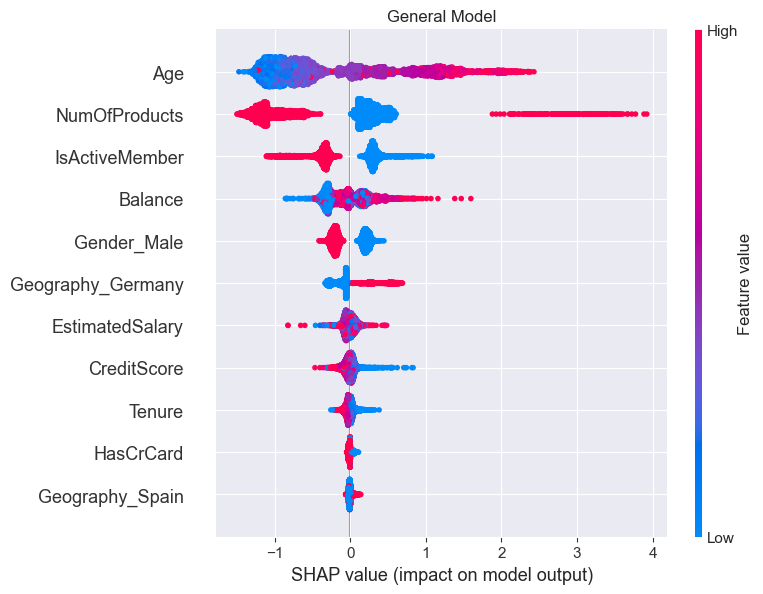


Вычисление SHAP values для: France Model


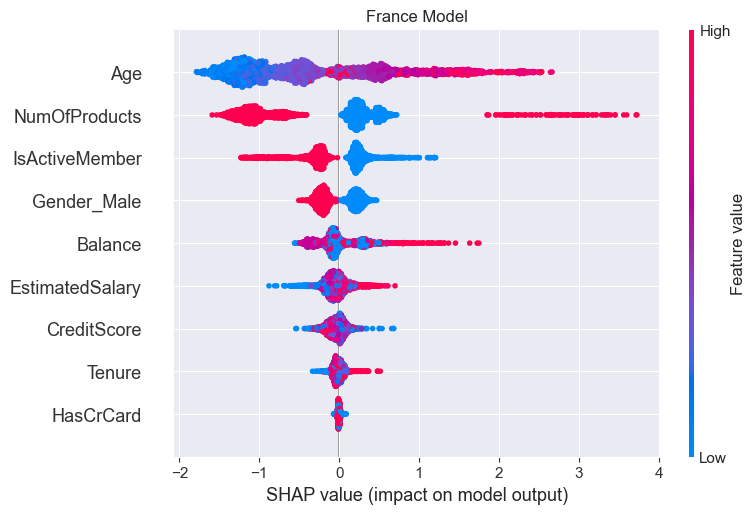


Вычисление SHAP values для: Germany Model


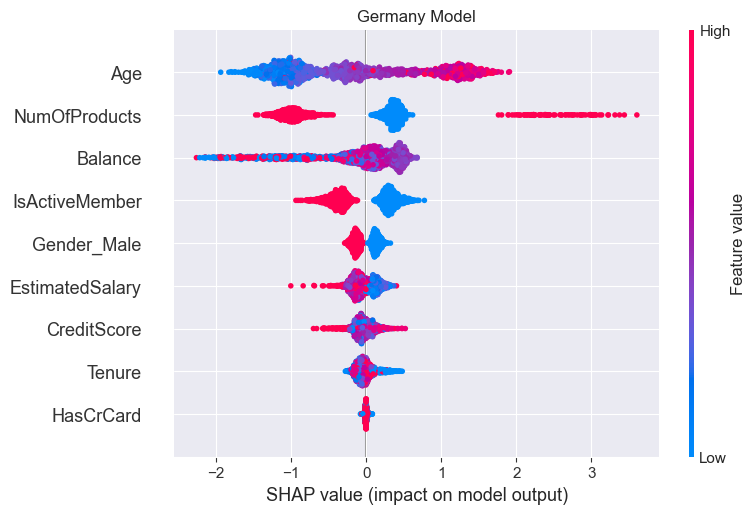


Вычисление SHAP values для: Spain Model


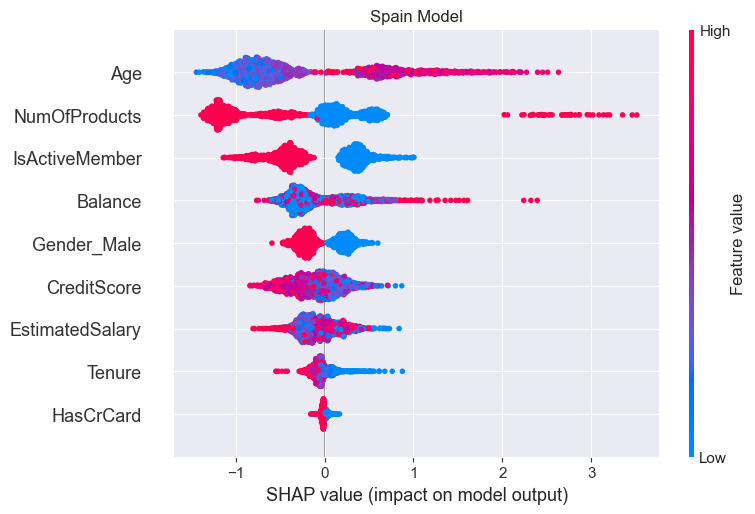

In [29]:
import shap

# --- Функция для SHAP Summary Plot (улучшенная) ---
def plot_shap_summary(model, X_data, title):
    """
    Рисует SHAP Summary Plot. Ожидает X_data в виде pandas DataFrame
    с корректными именами колонок.
    """
    if not isinstance(X_data, pd.DataFrame):
        print(f"Предупреждение для '{title}': X_data не является DataFrame. "
              "Имена признаков на графике могут быть некорректными (feature_0, feature_1...). "
              "Убедитесь, что передаете DataFrame с именами колонок.")

    print(f"\nВычисление SHAP values для: {title}")
    # Используем TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_data) # Передаем DataFrame

    plt.figure() # Создаем новую фигуру для каждого графика
    shap.summary_plot(shap_values, X_data, show=False)
    plt.title(title)
    plt.show()

# --- Вызовы функции plot_shap_summary ---
plot_shap_summary(general_xgb, general_X_train, "General Model")
plot_shap_summary(france_xgb, france_X_train, "France Model")
plot_shap_summary(germany_xgb, germany_X_train, "Germany Model")
plot_shap_summary(spain_xgb, spain_X_train, "Spain Model")

#### Финальный отбор признаков для стран

**Франция**:
1. **Age** (Важность: 0.360673, p-value: 0.000000)
   - Важность и p-value подтверждают, что это самый значимый признак.

2. **NumOfProducts** (Важность: 0.177536, p-value: 0.000000)
   - Сильный признак с низким p-value.

3. **Balance** (Важность: 0.114510, p-value: 0.000000)
   - низким p-value.

4. **IsActiveMember** (Важность: 0.042177, p-value: 0.000000)
   - Значимый признак.

**Германия**:
1. **Age** (Важность: 0.328026, p-value: 0.000000)
   - Важность и p-value подтверждают значимость.

2. **NumOfProducts** (Важность: 0.197016, p-value: 0.000000)
   - Второй по важности признак с низким p-value.

3. **Balance** (Важность: 0.159432, p-value: 0.000000)
   - Важный финансовый показатель.

4. **IsActiveMember** (Важность: 0.051730, p-value: 0.000000)
   - Тоже значимый признак.

5. **CreditScore** (Важность: 0.088376, p-value: 0.000000)
   - Тоже значимый признак.

**Испания**:
1. **Age** (Важность: 0.263506, p-value: 0.000000)
   - Самый значимый признак с низким p-value.

2. **NumOfProducts** (Важность: 0.153242, p-value: 0.000000)
   - Важность и p-value указывают на значимость.

3. **Balance** (Важность: 0.150375, p-value: 0.000000)
   - Фактор финансовой стабильности с низким p-value.

4. **IsActiveMember** (Важность: 0.065040, p-value: 0.032213)
   - значимость с p-value < 0.05.

### Доп. улучшение модели

##### Построим матрицы ошибок (confusion matrix) для каждой модели, чтобы проанализировать, как они справляются с классификацией клиентов на ушедших и оставшихся.

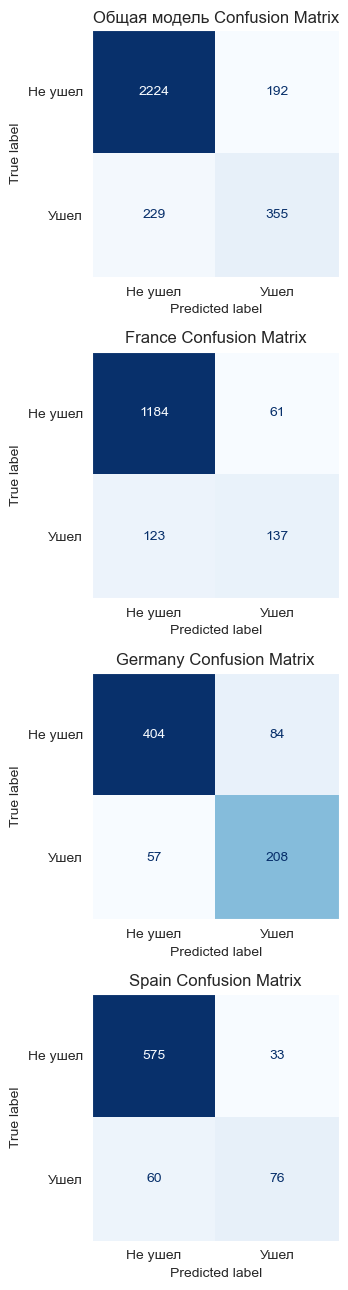

In [30]:
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Не ушел', 'Ушел'])

    disp.plot(ax=ax, values_format='d', cmap='Blues', colorbar=False)

    # 1) Отключаем сетку на осях
    disp.ax_.grid(False)

    ax.set_title(f"{title} Confusion Matrix")

# Предсказания для Random Forest моделей
general_y_pred_xgb = general_xgb.predict(general_X_test)
france_y_pred_xgb = france_xgb.predict(france_X_test)
germany_y_pred_xgb = germany_xgb.predict(germany_X_test)
spain_y_pred_xgb = spain_xgb.predict(spain_X_test)


# Построение графиков
fig, axes = plt.subplots(4, 1, figsize=(10, 13))

plot_confusion_matrix(general_y_test, general_y_pred_xgb, "Общая модель", axes[0])
plot_confusion_matrix(france_y_test, france_y_pred_xgb, "France", axes[1])
plot_confusion_matrix(germany_y_test, germany_y_pred_xgb, "Germany", axes[2])
plot_confusion_matrix(spain_y_test, spain_y_pred_xgb, "Spain", axes[3])

plt.tight_layout()
plt.show()

- У всех трех моделей для каждой страны наблюдается склонность к более высокой точности для класса 0 (не ушли), так как число TN значительно выше TP. Это отражает дисбаланс в данных и сложность предсказания класса 1 (ушли).
- Для каждой страны количество FN (ошибок, где ушли, но модель предсказала, что не ушли) довольно высоко. Это значит, что модель недостаточно уверенно выявляет клиентов, которые уходят.
- У моделей в Германии лучшая точность для класса 1, что заметно по относительно высокому числу TP (200) при умеренном FN (65). Для Франции и Испании FN значительно выше.

Таким образом, мы видим, что наша модель показывает хорошие результаты при предсказании класса **exited = 0** (клиенты остаются в банке), но справляется хуже с предсказанием класса **exited = 1** (клиенты, которые уходят).

Люди, которые уходят из банка, обойдутся ему дороже, поскольку привлечение новых клиентов требует значительно больше ресурсов, чем удержание текущих. Поэтому важно сфокусироваться на уменьшении **FN (ложноотрицательных)** — ситуаций, когда модель ошибочно считает, что клиент останется, хотя на самом деле он уйдёт.

Если наша модель успешно выявит больше таких клиентов (уменьшив FN), банк сможет предпринять меры для их удержания, что принесёт значительные выгоды. Например: предложение бонусов или скидок, снижение процентной ставки или персональная консультация

Минимизация FN возможна **за счёт изменения порога** классификации модели. Это позволит захватывать больше ушедших клиентов (увеличив recall) даже за счёт некоторого увеличения FP (ложноположительных), что менее критично, так как избыточные меры удержания обойдутся дешевле, чем потеря клиента.

##### Нахождение оптимальных порогов

Оптимальный порог выбирается как тот, при котором **максимизируется разница между TPR и FPR**.
Максимизируя TPR - FPR, мы ищем баланс. Мы хотим, чтобы модель хорошо находила ушедших клиентов (высокий TPR), но при этом не делала много ошибок, предсказывая уход там, где его нет (низкий FPR)

In [56]:

# General
general_y_prob_xgb = general_xgb.predict_proba(general_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(general_y_test, general_y_prob_xgb)
general_optimal_threshold = thresholds[np.argmax(tpr - fpr)]


# France
france_y_prob_xgb = france_xgb.predict_proba(france_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(france_y_test, france_y_prob_xgb)
france_optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Germany
germany_y_prob_xgb = germany_xgb.predict_proba(germany_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(germany_y_test, germany_y_prob_xgb)
germany_optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Spain
spain_y_prob_xgb = spain_xgb.predict_proba(spain_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(spain_y_test, spain_y_prob_xgb)
spain_optimal_threshold = thresholds[np.argmax(tpr - fpr)]

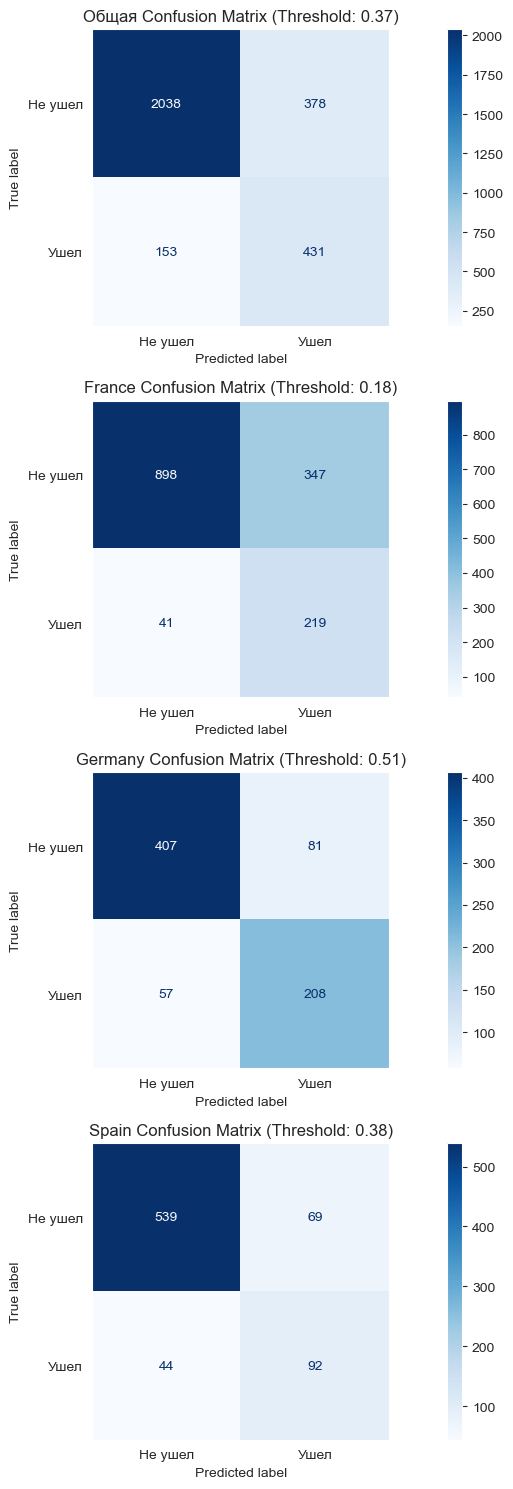

In [57]:
def plot_confusion_matrix_for_country(y_true, y_proba, optimal_threshold, country_name, ax):
    # Применяем оптимальный порог
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

    # Вычисляем матрицу ошибок
    cm = confusion_matrix(y_true, y_pred_optimal)
    # Визуализируем матрицу ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Не ушел', 'Ушел'])
    disp.plot(ax=ax, values_format='d', cmap='Blues')

    disp.ax_.grid(False)
    ax.set_title(f"{country_name} Confusion Matrix (Threshold: {optimal_threshold:.2f})")

# Создаем графики
_, axes = plt.subplots(4, 1, figsize=(12, 15))

# Франция
plot_confusion_matrix_for_country(general_y_test, general_y_prob_xgb, general_optimal_threshold, "Общая", axes[0])

# Франция
plot_confusion_matrix_for_country(france_y_test, france_y_prob_xgb, france_optimal_threshold, "France", axes[1])

# Германия
plot_confusion_matrix_for_country(germany_y_test, germany_y_prob_xgb, germany_optimal_threshold, "Germany", axes[2])

# Испания
plot_confusion_matrix_for_country(spain_y_test, spain_y_prob_xgb, spain_optimal_threshold, "Spain", axes[3])

plt.tight_layout()
plt.show()

Посчитаем **точность** до выбора оптимального порога и после:

###### **До выбора оптимального порога:**
(по агрегации из 3 моделей разных стран):

Всего клиентов, которые не ушли из банка : 1245+488+608=2341.
- Из них правильно классифицировано: 1184+404+575=2163 (92%).

Всего клиентов, которые ушли из банка: 260+265+136=661.
- Из них правильно классифицировано: 153+200+81=421 (63%).

(общая модель):

Всего клиентов, которые не ушли из банка : 2416.
- Из них правильно классифицировано: 2224 (92%).

Всего клиентов, которые ушли из банка: 594.
- Из них правильно классифицировано: 355 (59%).

**После выбора оптимального порога:**
(по агрегации из 3 моделей разных стран):

Всего клиентов, которые не ушли из банка: 1245+488+608=2341.
- Из них правильно классифицировано: 1049+422+470=1844 (78%).

Всего клиентов, которые ушли из банка: 260+265+136=661.
- Из них правильно классифицировано: 184+200+107=519 (78%).

(общая модель):

Всего клиентов, которые не ушли из банка: 2416.
- Из них правильно классифицировано: 2038 (84%).

Всего клиентов, которые ушли из банка: 584.
- Из них правильно классифицировано: 431 (73%).

Так как когда речь идёт о churn-аналитике, компании предпочитают повышать recall для класса «Ушли» (ведь удержание клиента обычно дороже, чем случайно потратить усилия на неушедшего). Поэтому на практике чаще сдвигают порог.

Я смещаю порог в сторону повышения чувствительности к классу «Ушёл» и использую три отдельные модели для каждой страны, поскольку это даёт более высокий показатель точности по уходящим клиентам и учитывает локальные особенности данных. Таким образом я снижаю риск упустить действительно «ушедших» и лучше адаптируюсь к различиям между рынками, повышая общую эффективность удержания.

Точность для класса "Не ушёл" (Exited=0) снизилась с 91% до 83%.
Точность для класса "Ушёл" (Exited=1) увеличилась с 66% до 74%.


Мы видим, что хотя точность для клиентов, которые остались в банке, несколько снизилась (−8%), а точность для клиентов, которые ушли, выросла (+8%). В контексте задачи оттока клиентов это значительное улучшение, поскольку ушедшие клиенты обходятся банку дороже, и их правильная идентификация позволяет предпринять меры для удержания.

Еще можно отметить, что точность для класса "Ушел" значительно увеличилась, особенно во Франции (+12%) и Испании (+19%).
В Германии порог практически не изменился (по умолчанию был 0.5, а оптимальный порог 0.51) и поэтому точность тоже практически не изменилась для классов

# Выгрузка моделей

In [58]:
import joblib

joblib.dump({'model': france_xgb, 'threshold': 0.18}, 'models/model_france.pkl')
joblib.dump({'model': spain_xgb, 'threshold': 0.38}, 'models/model_spain.pkl')
joblib.dump({'model': germany_xgb, 'threshold': 0.51}, 'models/model_germany.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_france.pkl'